In [2]:
import pickle as pkl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import hmean
import json
import pandas as pd

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def diag_means(A):
    A = np.asarray(A)
    n, m = A.shape
    assert n == m, "expect square matrix"
    return np.array([A.diagonal(offset=k).mean() for k in range(-(n-1), n)])


In [4]:
models = {
    # "naive_model": "Base",
    # "llama3": "ICL",
    "llama3_ft": "ICL-FT",
    # "rag_untrained": "RAG",
    "rag_trained": "RAG-FT",
    # "memoryllm": "MemLLM",
    # "gnm_ablation": "GNM (Ablation)",
    "gnm": "GNM",
    
}

model_keys = list(models.keys())
model_names = list(models.values())

In [5]:
model_keys, model_names

(['llama3_ft', 'rag_trained', 'gnm'], ['ICL-FT', 'RAG-FT', 'GNM'])

In [6]:
model_colors = {
    "llama3_ft": pal[1],
    "rag_trained": pal[2],
    # "memoryllm": pal[4],
    "gnm": pal[0],
}

In [7]:
data = dict()

for model_key, model_name in models.items():

    data_root = f"../saved_evals/mixed_documents_seq_10/{model_key}/summary.json"

    # Open the file and load the data
    with open(data_root, 'r') as json_file:
        data_dict = json.load(json_file)

    data[model_key] = data_dict
    data[model_key]["model_name"] = model_name

In [8]:
len_rollout = 10
step_0 = len_rollout-1

rows = []

for k, v in data.items():

    total_refusal_score = hmean(
        np.array([
            # v['refusal_accuracy'][0],
            v['refusal_precision'][0],
            v['refusal_recall'][0],
            # v['refusal_specificity'][0],
        ])
    )

    #######################
    ### All Upper Triangle
    #######################

    print(k)

    # Use full matrix and compute step_0_offset dynamically
    fa_mat = np.array(v["fact_accuracy_matrix"])[0]
    mat_size = fa_mat.shape[0]
    step_0_offset = mat_size - 1
    
    # For upper triangle averaging (all time steps in matrix)
    fa_mat_trunc = fa_mat[:len_rollout, :len_rollout]
    all_acc = np.mean(fa_mat_trunc[np.triu_indices_from(fa_mat_trunc, k=0)])
    print("all_acc", all_acc)

    # Get diagonal means for retention analysis (offsets 0 onwards)
    f_acc_diags = diag_means(fa_mat)[step_0_offset:]

    fs_mat = np.array(v["fact_specificity_matrix"])[0]
    fs_mat_trunc = fs_mat[:len_rollout, :len_rollout]
    all_spec = np.mean(fs_mat_trunc[np.triu_indices_from(fs_mat_trunc, k=0)])
    print("all_spec", all_spec)

    f_spec_diags = diag_means(fs_mat)[step_0_offset:]

    fsel_mat = np.array(v["fact_selectivity_matrix"])[0]
    fsel_mat_trunc = fsel_mat[:len_rollout, :len_rollout]
    all_sel = np.mean(fsel_mat_trunc[np.triu_indices_from(fsel_mat_trunc, k=0)])
    print("all_sel", all_sel)

    f_sel_diags = diag_means(fsel_mat)[step_0_offset:]

    total_all_score = harmonic_mean = hmean(
        np.array(
            [
                all_acc,
                all_spec,
                all_sel
            ]
        )
    )
    print("total all score", total_all_score)
    print("---")

    f_score_diags = np.mean(np.vstack([f_acc_diags, f_spec_diags, f_sel_diags]), 0)
    # f_score_diags = np.array([hmean([f_acc_diags[i], f_spec_diags[i], f_sel_diags[i]]) 
    #                       for i in range(len(f_acc_diags))])

    data[k]["fact_score_retention"] = f_score_diags
    
    # refusal_f1_over_time = np.mean(np.vstack([v["refusal_precision_over_time"], v["refusal_recall_over_time"]]), 0)[:len_rollout]
    # print(refusal_f1_over_time)
    refusal_precision = np.array(v["refusal_precision_over_time"])[0,:len_rollout]
    refusal_recall = np.array(v["refusal_recall_over_time"])[0,:len_rollout]
    refusal_f1_over_time = np.array([hmean([refusal_precision[i], refusal_recall[i]]) 
                                    for i in range(len(refusal_precision))])
    
    scale = 100

    row = [
        # k,
        v["model_name"],
        total_all_score*scale,
        all_acc*scale,
        all_spec*scale,
        all_sel*scale,
        v['format_accuracy'][0]*scale,
        v['format_selectivity'][0]*scale,
        total_refusal_score*scale,
        v['refusal_precision'][0]*scale,
        v['refusal_recall'][0]*scale,
    ]

    rows.append(row)

columns = [
    # "model_key",
    "model_name",
    "total_all_score",
    "all_fact_accuracy",
    "all_fact_specificity",
    "all_fact_selectivity",    
    'format_accuracy',
    'format_selectivity',
    'total_refusal_score',
    'refusal_precision',
    'refusal_recall',

]

results_df = pd.DataFrame(rows, columns=columns)
results_df.round(1)

llama3_ft
all_acc 0.7305528109723871
all_spec 0.7560512380166488
all_sel 0.43566812005910005
total all score 0.6015865907368311
---
rag_trained
all_acc 0.7359645410017533
all_spec 0.7580892432819714
all_sel 0.6386893033981323
total all score 0.7069513410901599
---
gnm
all_acc 0.9178990320725875
all_spec 0.7809802185405385
all_sel 0.6764564655043862
total all score 0.779589649067501
---


,model_name,total_all_score,all_fact_accuracy,all_fact_specificity,all_fact_selectivity,format_accuracy,format_selectivity,total_refusal_score,refusal_precision,refusal_recall
0,ICL-FT,60.2,73.1,75.6,43.6,4.3,99.7,89.8,92.7,87.1
1,RAG-FT,70.7,73.6,75.8,63.9,0.0,99.9,69.4,65.6,73.7
2,GNM,78.0,91.8,78.1,67.6,67.4,100.0,93.2,88.7,98.1


In [9]:
results_df.columns

Index(['model_name', 'total_all_score', 'all_fact_accuracy',
       'all_fact_specificity', 'all_fact_selectivity', 'format_accuracy',
       'format_selectivity', 'total_refusal_score', 'refusal_precision',
       'refusal_recall'],
      dtype='object')

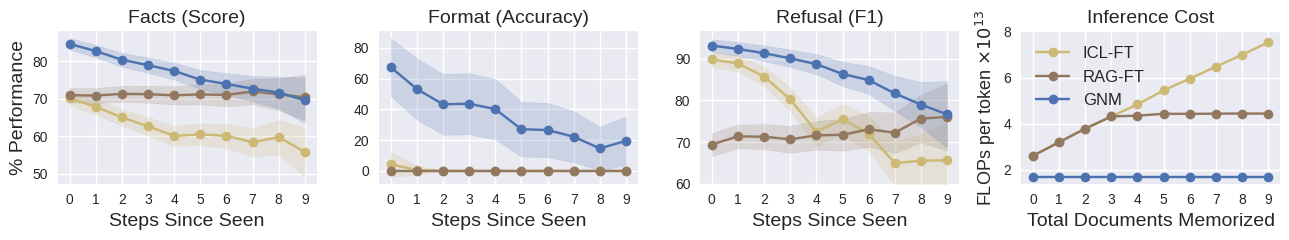

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
import json
import numpy as np
from scipy.stats import hmean

plt.style.use('seaborn-v0_8')
pal = sns.color_palette("deep", 10)
model_colors = {
    "Ablation": pal[7],
    "ICL-FT": pal[8],
    "llama3_ft": pal[8],
    "RAG-FT": pal[5],
    "rag_trained": pal[5],
    "MemLLM": pal[9],
    "GNM": pal[0],
    "gnm": pal[0]
}
curve_len = 10

comp_models = [
    'llama3_ft', 
    'rag_trained',
    'gnm'
]

plot_cols = [
    'fact_score_retention',
    'format_retention',
    'refusal_f1_over_time',
    'flops_per_token',
]

plot_titles = {
    'fact_score_retention': "Facts (Score)",
    'format_retention': "Format (Accuracy)",
    'refusal_f1_over_time': "Refusal (F1)",
    'flops_per_token': "Inference Cost",
}

# Binomial CI function
def binomial_ci(p, n, z=1.96):
    """Returns 95% CI half-width for a proportion."""
    se = np.sqrt(p * (1 - p) / n)
    return z * se

n_episodes = 216

# Sample counts for facts: (curve_len - i) diagonals * 216 episodes (full count)
n_samples_facts = np.array([(curve_len - i) * n_episodes for i in range(curve_len)])

# Sample counts for refusal: halved (each step is either fact, format, or refusal - not all three)
n_samples_refusal = np.array([(curve_len - i) * n_episodes // 2 for i in range(curve_len)])

# Sample counts for format: 24 per x-axis element (216 episodes / 9 format types, evenly distributed)
n_samples_format = np.full(curve_len, 24)

# Load FLOP data
flop_data = dict()
flop_scale = 1e13

for model_key in comp_models:
    data_root = f"../saved_evals/mixed_documents_analysis/{model_key}_flops/summary.json"
    with open(data_root, 'r') as json_file:
        flop_dict = json.load(json_file)
    flop_data[model_key] = flop_dict

fig, axs = plt.subplots(1, len(plot_cols), figsize=(13, 2.5))

x = np.arange(curve_len)

for i, curve in enumerate(plot_cols):
    for model_key in comp_models:
        if curve == "fact_score_retention":
            model_data = np.array(data[model_key][curve])[:curve_len]
            n_samples = n_samples_facts
        elif curve == "refusal_f1_over_time":
            refusal_precision = np.array(data[model_key]["refusal_precision_over_time"])[0,:curve_len]
            refusal_recall = np.array(data[model_key]["refusal_recall_over_time"])[0,:curve_len]
            refusal_f1 = np.array([hmean([refusal_precision[i], refusal_recall[i]]) 
                                for i in range(len(refusal_precision))])
            model_data = refusal_f1
            n_samples = n_samples_refusal
        elif curve == "flops_per_token":
            fpt = np.array(flop_data[model_key]["flops_per_token"][0])/flop_scale
            model_data = fpt[:curve_len]
            axs[i].plot(x, model_data, "-o", label=models[model_key], color=model_colors[model_key])
            continue  # Skip CI and percentage multiplication for FLOPs
        elif curve == "format_retention":
            model_data = np.array(data[model_key][curve])[0,:curve_len]
            n_samples = n_samples_format  # Only 24 samples per x-axis element
        else:
            model_data = np.array(data[model_key][curve])[0,:curve_len]
            n_samples = n_samples_facts
        
        # Compute 95% CI and plot shaded region
        ci = binomial_ci(model_data, n_samples)
        axs[i].fill_between(x, (model_data - ci) * 100, (model_data + ci) * 100, 
                            color=model_colors[model_key], alpha=0.2)
        axs[i].plot(x, model_data*100, "-o", label=models[model_key], color=model_colors[model_key])

    axs[i].set_title(plot_titles[curve], fontsize=14)
    axs[i].set_xticks(list(x))
    if i == 3:
        axs[i].set_xlabel("Total Documents Memorized", fontsize=14)
    else:
        axs[i].set_xlabel("Steps Since Seen", fontsize=14)

axs[2].set_ylim(60, None)
axs[3].set_ylim(None, 8)

axs[3].legend(fontsize=12, loc="upper left")

axs[0].set_ylabel("% Performance", fontsize=14)
axs[3].set_ylabel(r"FLOPs per token $\times 10^{13}$", fontsize=13)

fig.tight_layout()

plt.savefig("../plots/mixed_docs_curves_f1_flops.png", dpi=600, bbox_inches="tight")
plt.show()

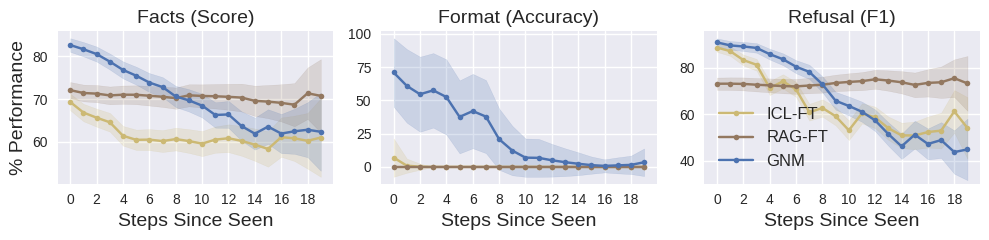

In [23]:
# Load data for sequence length 20
data_seq20 = dict()

for model_key, model_name in models.items():
    data_root = f"../saved_evals/mixed_documents/{model_key}/summary.json"
    with open(data_root, 'r') as json_file:
        data_dict = json.load(json_file)
    data_seq20[model_key] = data_dict
    data_seq20[model_key]["model_name"] = model_name

# Compute fact_score_retention for seq20 data
len_rollout_20 = 20
for model_key in comp_models:
    fa_mat = np.array(data_seq20[model_key]["fact_accuracy_matrix"])[0]
    mat_size = fa_mat.shape[0]
    step_0_offset = mat_size - 1
    f_acc_diags = diag_means(fa_mat)[step_0_offset:]
    
    fs_mat = np.array(data_seq20[model_key]["fact_specificity_matrix"])[0]
    f_spec_diags = diag_means(fs_mat)[step_0_offset:]
    
    fsel_mat = np.array(data_seq20[model_key]["fact_selectivity_matrix"])[0]
    f_sel_diags = diag_means(fsel_mat)[step_0_offset:]
    
    f_score_diags = np.mean(np.vstack([f_acc_diags, f_spec_diags, f_sel_diags]), 0)
    data_seq20[model_key]["fact_score_retention"] = f_score_diags

# Parameters for seq20
n_episodes_20 = 108
curve_len_20 = 20

# Sample counts for seq20
n_samples_facts_20 = np.array([(curve_len_20 - i) * n_episodes_20 for i in range(curve_len_20)])
n_samples_refusal_20 = np.array([(curve_len_20 - i) * n_episodes_20 // 2 for i in range(curve_len_20)])
n_samples_format_20 = np.full(curve_len_20, 12)  # 108 / 9 format types

plot_cols_20 = [
    'fact_score_retention',
    'format_retention',
    'refusal_f1_over_time',
]

plot_titles_20 = {
    'fact_score_retention': "Facts (Score)",
    'format_retention': "Format (Accuracy)",
    'refusal_f1_over_time': "Refusal (F1)",
}

fig, axs = plt.subplots(1, len(plot_cols_20), figsize=(10, 2.5))

x_20 = np.arange(curve_len_20)

for i, curve in enumerate(plot_cols_20):
    for model_key in comp_models:
        if curve == "fact_score_retention":
            model_data = np.array(data_seq20[model_key][curve])[:curve_len_20]
            n_samples = n_samples_facts_20
        elif curve == "refusal_f1_over_time":
            refusal_precision = np.array(data_seq20[model_key]["refusal_precision_over_time"])[0,:curve_len_20]
            refusal_recall = np.array(data_seq20[model_key]["refusal_recall_over_time"])[0,:curve_len_20]
            refusal_f1 = np.array([hmean([refusal_precision[j], refusal_recall[j]]) 
                                for j in range(len(refusal_precision))])
            model_data = refusal_f1
            n_samples = n_samples_refusal_20
        elif curve == "format_retention":
            model_data = np.array(data_seq20[model_key][curve])[0,:curve_len_20]
            n_samples = n_samples_format_20
        else:
            model_data = np.array(data_seq20[model_key][curve])[0,:curve_len_20]
            n_samples = n_samples_facts_20
        
        ci = binomial_ci(model_data, n_samples)
        axs[i].fill_between(x_20, (model_data - ci) * 100, (model_data + ci) * 100, 
                            color=model_colors[model_key], alpha=0.2)
        axs[i].plot(x_20, model_data*100, "-o", label=models[model_key], color=model_colors[model_key], markersize=4)

    axs[i].set_title(plot_titles_20[curve], fontsize=14)
    axs[i].set_xticks(list(x_20)[::2])
    axs[i].set_xlabel("Steps Since Seen", fontsize=14)

axs[2].set_ylim(30, None)
axs[2].legend(fontsize=12, loc="lower left")
axs[0].set_ylabel("% Performance", fontsize=14)

fig.tight_layout()

plt.savefig("../plots/mixed_docs_curves_seq20.png", dpi=600, bbox_inches="tight")
plt.show()